# CS-433 Machine Learning
## Project 1 : The Higgs Boson Challenge

Christian Abbet, Patryk Oleniuk, Gaétan Ramet

We first start by loading our training data and splitting it in a training set (80%) and a validation set (20%)

In [87]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scripts.implementations as lib  # Add personal library
import scripts.proj1_helpers as helper  # Add personal library
import scripts.ml as ml # Add personal library

%matplotlib inline
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4)

DATA_FOLDER = 'data'
DATA_TRAIN = os.path.join(DATA_FOLDER, 'train.csv')
DATA_TEST = os.path.join(DATA_FOLDER, 'test.csv')

y, x, ids, header = helper.load_csv_data(DATA_TRAIN)
y_train, x_train,  y_validation, x_validation = lib.sep_valid_train_data(x,y, 0.8);


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Data Exploration and Cleaning 


## 1.1 Data Exploration

We first load the data to see what is the repartition of the data. The two possible classes in for the measurements are `s` for signal, indicating the presence of a Higgs boson and `b` for backgroud noise. In this case around 2/3 of the data (65.73%) is labeled as background.

In [88]:
print('Repartition of {} labels, s: {:.2f}%, b: {:.2f}%'.format(
    len(y_train), np.mean(y_train==1)*100, np.mean(y_train==-1)*100))

Repartition of 200000 labels, s: 34.27%, b: 65.73%


According to [the Higgs boson machine learning challenge](https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf) some variable are indicated as "may be undefined" when it can happen that they are meaning-
less or cannot be computed. In this case, their value is set to -999.0, which is outside the normal range of all variables. We will set them to NaN so they will be easier to handle.

In [89]:
x_train[x_train == -999] = np.nan
x_validation[x_validation == -999] = np.nan

Let's now take a look at the repartition of the NaN along the features. We can see that some features seems to have the same amount of NaN value. The second graph shows that some features seems to have NaNs values axactly at the same location. We distinguish here 4 different kind of nan distributions: For some feature, we have a high proportions of nans, while for others, it is very low and we don't even see it on the plot. Having so many NaNs in our data lead us to think we can propably use them in some way

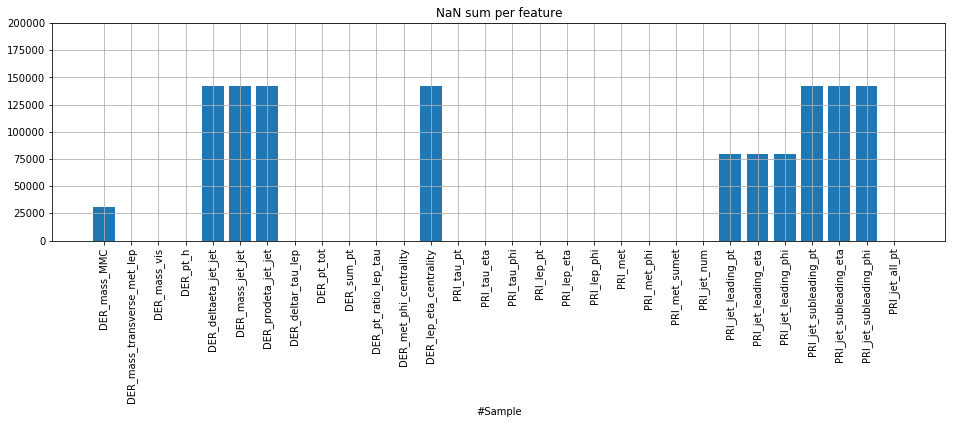

In [90]:
plt.figure(figsize=(16,4))
plt.bar(np.arange(len(header)), np.sum(np.isnan(x_train), axis=0))
plt.xticks(np.arange(len(header)), header, rotation='vertical')
plt.ylim(0, len(y_train)); plt.xlabel('Features'); plt.xlabel('#Sample'); plt.title('NaN sum per feature')
plt.grid(); plt.show();

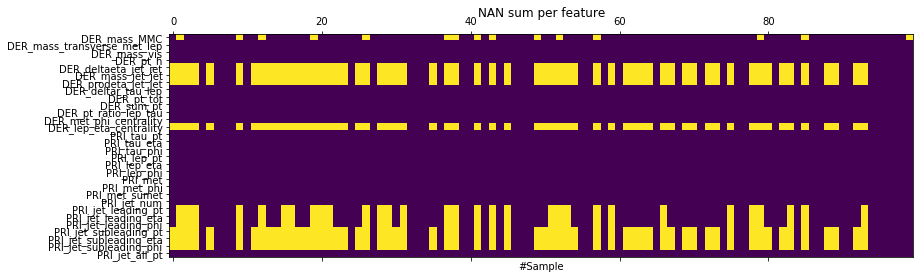

In [91]:
plt.figure(figsize=(14, 20))
plt.matshow(np.isnan(x_train)[:100, :].T)
plt.yticks(np.arange(len(header)), header)
plt.xlabel('Features'); plt.xlabel('#Sample'); plt.title('NAN sum per feature')
plt.show(); 

Does the NaN value gave us any information (`s` or `b`) ? We can see that for some features, the presence of Nan values seems to change the repartition of signal and background measurement : this means that we can use information from the presence of NaNs for classification

In [92]:

for i,feature in enumerate(x_train.T):
    print('Feature {:d} : NaN is present, s: {:.2f}, b: {:.2f}'.format(i,
        np.mean((y_train[(np.isnan(feature))] == 1)),
        np.mean((y_train[(np.isnan(feature))] == -1))))
    print('Feature {:d} : NaN is NOT present, s: {:.2f}, b: {:.2f}'.format(i,
        np.mean((y_train[~(np.isnan(feature))] == 1)),
        np.mean((y_train[~(np.isnan(feature))] == -1))))
    pass
print('NaN is present, s: {:.2f}, b: {:.2f}'.format(
     np.mean(y_train[np.any(np.isnan(x_train), axis=1)] == 1), 
     np.mean(y_train[np.any(np.isnan(x_train), axis=1)] == -1)))
print('NaN is not present, s: {:.2f}, b: {:.2f}'.format(
     np.mean(y_train[~np.any(np.isnan(x_train), axis=1)] == 1), 
     np.mean(y_train[~np.any(np.isnan(x_train), axis=1)] == -1)))

#for i, feature in enumerate(x_train.T):
#    print(' Feature {:d}: NaN is present, s: {:.2f}, b: {:.2f}'.format(i,
#        np.mean(y_train[np.any(np.isnan(feature), axis=0)] == 1), 
#        np.mean(y_train[np.any(np.isnan(feature), axis=0)] == -1)))
#    print(' Feature {:d} : NaN is not present, s: {:.2f}, b: {:.2f}'.format(i,
#        np.mean(y_train[~np.any(np.isnan(feature), axis=0)] == 1), 
#        np.mean(y_train[~np.any(np.isnan(feature), axis=0)] == -1)))

Feature 0 : NaN is present, s: 0.08, b: 0.92
Feature 0 : NaN is NOT present, s: 0.39, b: 0.61
Feature 1 : NaN is present, s: nan, b: nan
Feature 1 : NaN is NOT present, s: 0.34, b: 0.66
Feature 2 : NaN is present, s: nan, b: nan
Feature 2 : NaN is NOT present, s: 0.34, b: 0.66
Feature 3 : NaN is present, s: nan, b: nan
Feature 3 : NaN is NOT present, s: 0.34, b: 0.66
Feature 4 : NaN is present, s: 0.30, b: 0.70
Feature 4 : NaN is NOT present, s: 0.45, b: 0.55
Feature 5 : NaN is present, s: 0.30, b: 0.70
Feature 5 : NaN is NOT present, s: 0.45, b: 0.55
Feature 6 : NaN is present, s: 0.30, b: 0.70
Feature 6 : NaN is NOT present, s: 0.45, b: 0.55
Feature 7 : NaN is present, s: nan, b: nan
Feature 7 : NaN is NOT present, s: 0.34, b: 0.66
Feature 8 : NaN is present, s: nan, b: nan
Feature 8 : NaN is NOT present, s: 0.34, b: 0.66
Feature 9 : NaN is present, s: nan, b: nan
Feature 9 : NaN is NOT present, s: 0.34, b: 0.66
Feature 10 : NaN is present, s: nan, b: nan
Feature 10 : NaN is NOT pres

/Users/patryk/anaconda/envs/ada/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/patryk/anaconda/envs/ada/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Feature 18 : NaN is present, s: nan, b: nan
Feature 18 : NaN is NOT present, s: 0.34, b: 0.66
Feature 19 : NaN is present, s: nan, b: nan
Feature 19 : NaN is NOT present, s: 0.34, b: 0.66
Feature 20 : NaN is present, s: nan, b: nan
Feature 20 : NaN is NOT present, s: 0.34, b: 0.66
Feature 21 : NaN is present, s: nan, b: nan
Feature 21 : NaN is NOT present, s: 0.34, b: 0.66
Feature 22 : NaN is present, s: nan, b: nan
Feature 22 : NaN is NOT present, s: 0.34, b: 0.66
Feature 23 : NaN is present, s: 0.25, b: 0.75
Feature 23 : NaN is NOT present, s: 0.40, b: 0.60
Feature 24 : NaN is present, s: 0.25, b: 0.75
Feature 24 : NaN is NOT present, s: 0.40, b: 0.60
Feature 25 : NaN is present, s: 0.25, b: 0.75
Feature 25 : NaN is NOT present, s: 0.40, b: 0.60
Feature 26 : NaN is present, s: 0.30, b: 0.70
Feature 26 : NaN is NOT present, s: 0.45, b: 0.55
Feature 27 : NaN is present, s: 0.30, b: 0.70
Feature 27 : NaN is NOT present, s: 0.45, b: 0.55
Feature 28 : NaN is present, s: 0.30, b: 0.70
Feat

We can also take a look at the feature ranges. it can give us insights of the data. We can see that features (16), (19), (21), (26) and (29) are actually angles (range in $[-\pi, \pi]$). To be certain we checked it directly on the documentation. We decided to also use cosines and sines of these angles as features, as they might be relevant for classification. Note that we are ignoring the NaN values to compute the min and max.

We have to be careful with those results since the output gives us no imformation about the data distribution!

In [93]:
print("Base Features: \n")
for i, feature in enumerate(x_train.T):
    print('Feature {} - {} has range: [{:.4f}, {:.4f}]'.format(
        i+1, header[i], np.nanmin(feature), np.nanmax(feature)))

Base Features: 

Feature 1 - DER_mass_MMC has range: [9.2220, 1192.0260]
Feature 2 - DER_mass_transverse_met_lep has range: [0.0000, 690.0750]
Feature 3 - DER_mass_vis has range: [7.2020, 1329.9130]
Feature 4 - DER_pt_h has range: [0.0000, 2834.9990]
Feature 5 - DER_deltaeta_jet_jet has range: [0.0000, 8.5030]
Feature 6 - DER_mass_jet_jet has range: [14.9920, 4543.9130]
Feature 7 - DER_prodeta_jet_jet has range: [-18.0660, 16.6480]
Feature 8 - DER_deltar_tau_lep has range: [0.2240, 5.6840]
Feature 9 - DER_pt_tot has range: [0.0000, 2834.9990]
Feature 10 - DER_sum_pt has range: [46.1040, 1852.4620]
Feature 11 - DER_pt_ratio_lep_tau has range: [0.0470, 19.6720]
Feature 12 - DER_met_phi_centrality has range: [-1.4140, 1.4140]
Feature 13 - DER_lep_eta_centrality has range: [0.0000, 1.0000]
Feature 14 - PRI_tau_pt has range: [20.0000, 622.8620]
Feature 15 - PRI_tau_eta has range: [-2.4990, 2.4970]
Feature 16 - PRI_tau_phi has range: [-3.1420, 3.1420]
Feature 17 - PRI_lep_pt has range: [26.0

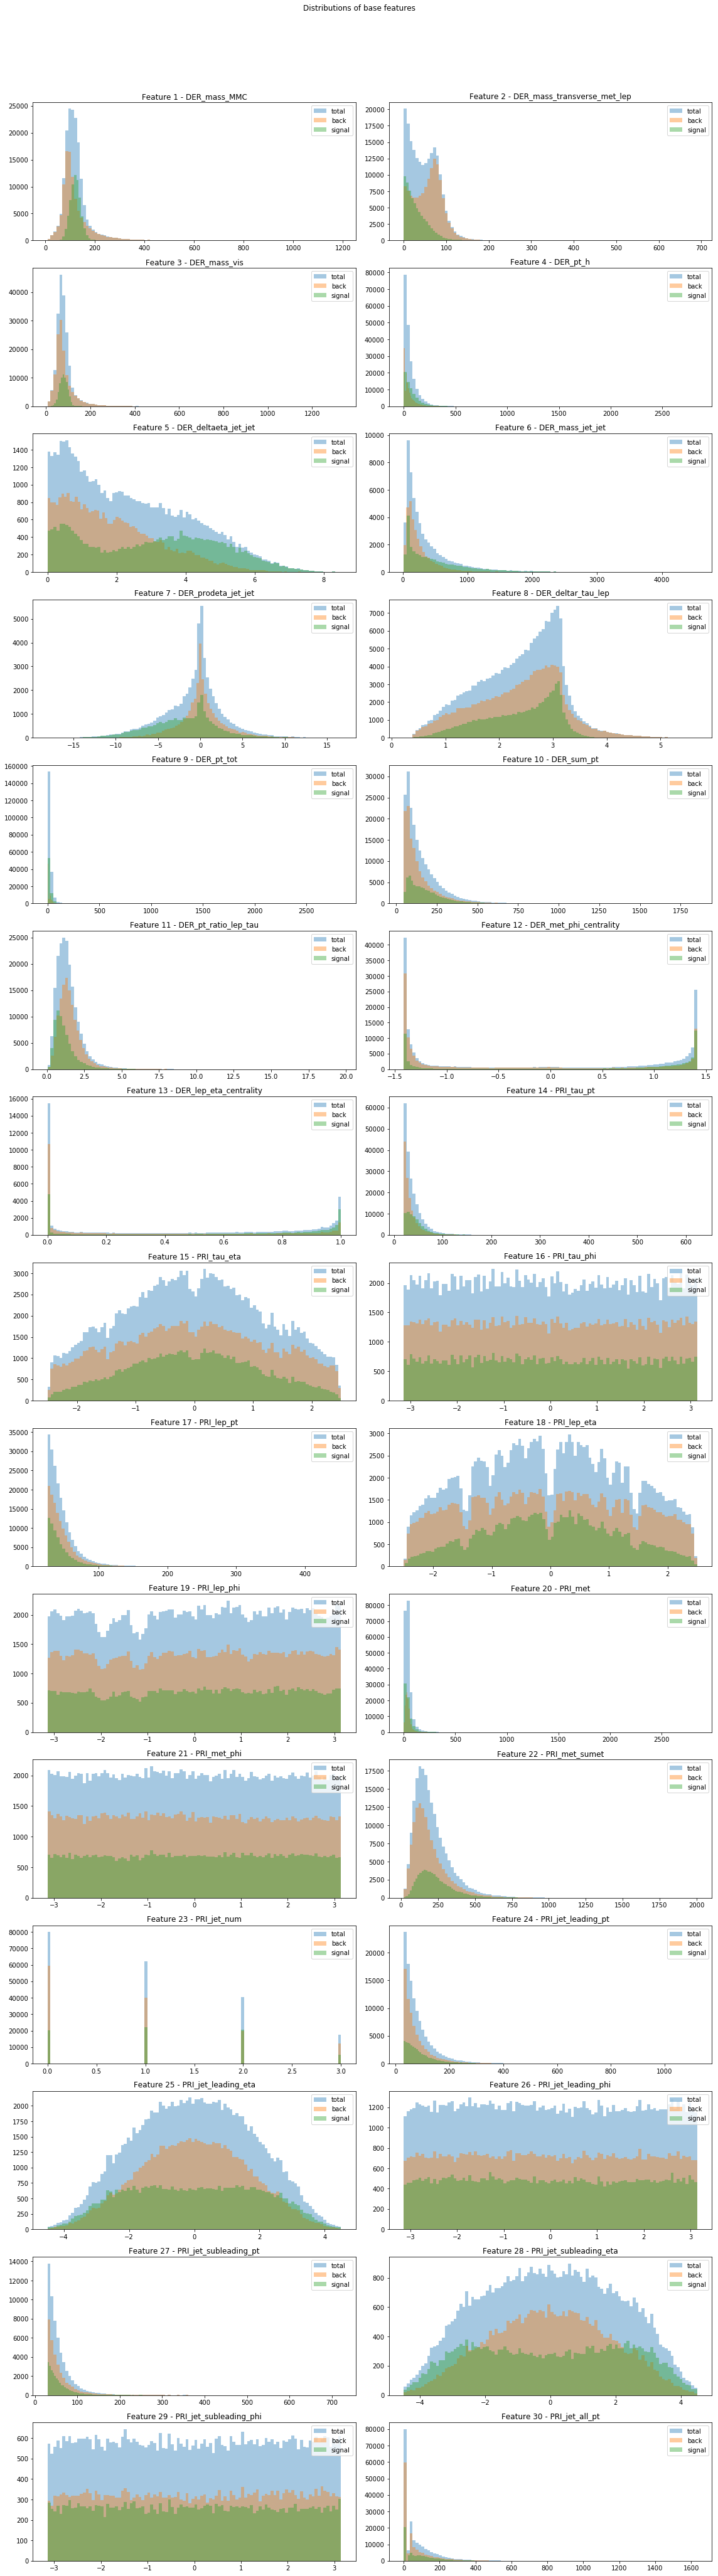

In [94]:
plt.figure(figsize=(16,60))

for i, feature in enumerate(x_train.T):
    plt.subplot(15, 2, i+1)
    id_keep = ~np.isnan(feature)
    id_b = np.logical_and(y_train == -1, id_keep)
    id_s = np.logical_and(y_train == 1, id_keep)
    plt.hist(feature[id_keep], bins=100, alpha=0.4, label='total')
    plt.hist(feature[id_b], alpha=0.4, bins=100, label='back')
    plt.hist(feature[id_s], alpha=0.4, bins=100, label='signal')
    plt.title('Feature {} - {}'.format(i+1, header[i]))
    plt.legend()
plt.suptitle("Distributions of base features")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


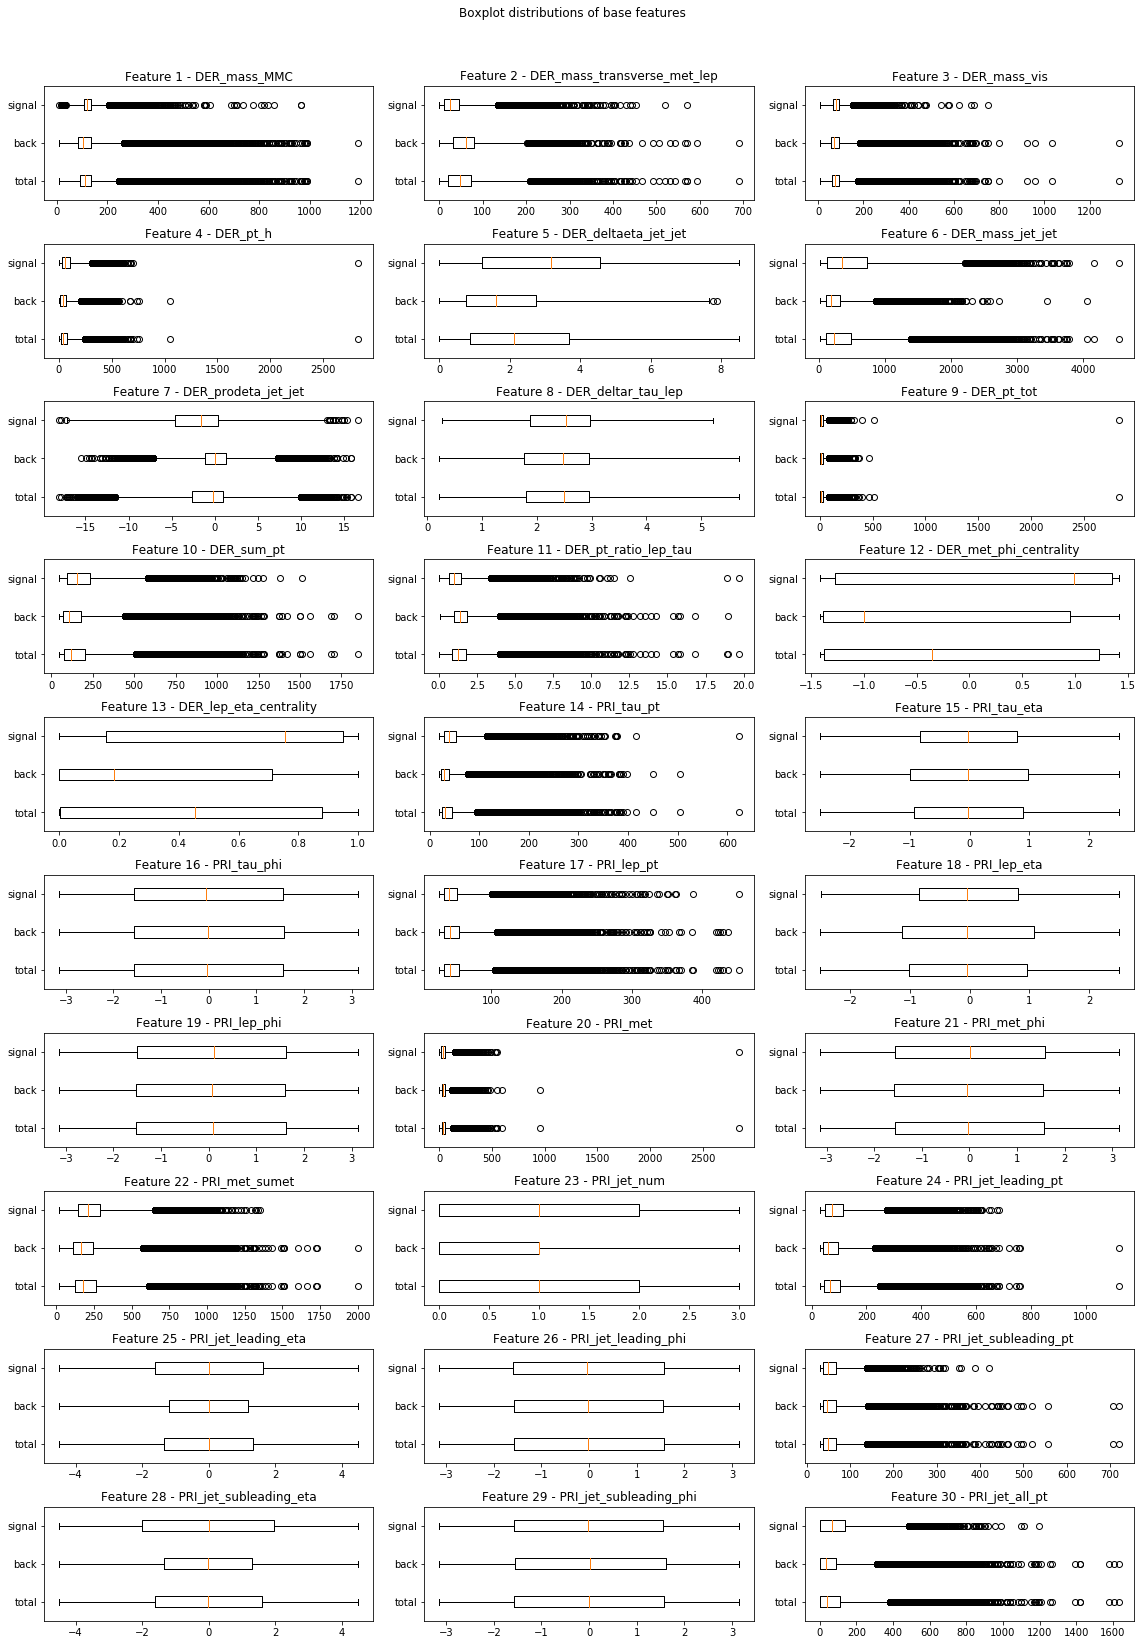

In [95]:
plt.figure(figsize=(16,24))

for i, feature in enumerate(x_train.T):
    plt.subplot(10, 3, i+1)
    id_keep = ~np.isnan(feature)
    id_b = np.logical_and(y_train == -1, id_keep)
    id_s = np.logical_and(y_train == 1, id_keep)
    plt.boxplot([feature[id_keep], feature[id_b], feature[id_s]], whis=2.5, 
                vert=False, labels=['total', 'back', 'signal'])
    plt.title('Feature {} - {}'.format(i+1, header[i]))
plt.suptitle("Boxplot distributions of base features")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


## 1.4 Feature augmentation

We will now use the information gathered in previous section to generate new features that are more helpful for classification. First, we will start working with the angles, by adding new features that are the cosines and sines of each angle.

In [96]:
id_angle = [15, 18, 20, 25, 28] # The ids of the features that are angles
x_aug, header = ml.augmented_feat_angle(x_train, id_angle, header)

for i, feature in enumerate(x_aug.T):
    print('Feature {} - {} has range: [{:.4f}, {:.4f}]'.format(
        i+1, header[i], np.nanmin(feature), np.nanmax(feature)))

Feature 1 - DER_mass_MMC has range: [9.2220, 1192.0260]
Feature 2 - DER_mass_transverse_met_lep has range: [0.0000, 690.0750]
Feature 3 - DER_mass_vis has range: [7.2020, 1329.9130]
Feature 4 - DER_pt_h has range: [0.0000, 2834.9990]
Feature 5 - DER_deltaeta_jet_jet has range: [0.0000, 8.5030]
Feature 6 - DER_mass_jet_jet has range: [14.9920, 4543.9130]
Feature 7 - DER_prodeta_jet_jet has range: [-18.0660, 16.6480]
Feature 8 - DER_deltar_tau_lep has range: [0.2240, 5.6840]
Feature 9 - DER_pt_tot has range: [0.0000, 2834.9990]
Feature 10 - DER_sum_pt has range: [46.1040, 1852.4620]
Feature 11 - DER_pt_ratio_lep_tau has range: [0.0470, 19.6720]
Feature 12 - DER_met_phi_centrality has range: [-1.4140, 1.4140]
Feature 13 - DER_lep_eta_centrality has range: [0.0000, 1.0000]
Feature 14 - PRI_tau_pt has range: [20.0000, 622.8620]
Feature 15 - PRI_tau_eta has range: [-2.4990, 2.4970]
Feature 16 - PRI_tau_phi has range: [-3.1420, 3.1420]
Feature 17 - PRI_lep_pt has range: [26.0000, 452.4340]
Fe

We will now try to generate new meaningful features by multiplying together the basic features and evaluating the difference between the median of the signal data and the background data for each new feature to determine which one are relevant:

In [97]:
dim = x_aug.shape[1]
m_b = np.zeros((dim, dim)) # the background medians
m_s = np.zeros((dim, dim)) # the signal medians
m_d = np.zeros((dim, dim)) # the difference medians

for i, f1 in enumerate(x_aug.T):
    for j, f2 in enumerate(x_aug.T):
        if i == j:
            f_res = f1
        else:
            f_res = f1*f2
        id_keep = ~np.isnan(f_res)
        id_b = np.logical_and(y_train == -1, id_keep)
        id_s = np.logical_and(y_train == 1, id_keep)
        f_norm = (f_res-np.nanmean(f_res))/np.nanstd(f_res) # We normalize the features
        m_b[i,j] = np.median(f_norm[id_b])
        m_s[i,j] = np.median(f_norm[id_s])
        m_d[i,j] = np.median(f_norm[id_b]) - np.median(f_norm[id_s])

We also want to enforce the new features to be different from the old feature, so we penalize the median difference of the new feature by the one of it's first component in the product

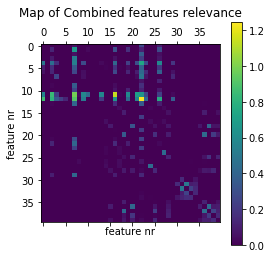

In [98]:
plt.figure(figsize=(10, 10))
values_to_plot = np.abs(m_d)-np.abs(np.diag(m_d))
values_to_plot[values_to_plot <0] = 0.0 # thresholding to better see where are the highest vals
plt.matshow(values_to_plot ) 
plt.colorbar()
plt.title('Map of Combined features relevance', y=1.12, fontsize=12)
plt.xlabel('feature nr')
plt.ylabel('feature nr')
plt.show()

Having a look at the new features distributions allows us to see that they separate signal from background much better than the base features.

In [99]:
tresh_id = np.nonzero((np.abs(m_d)-np.abs(np.diag(m_d))).flatten() > 0.4)
res = np.unravel_index(tresh_id, (dim, dim))
combs = np.array(res).reshape((2,-1)).T

# Take only unique pairs
combs = np.sort(combs, axis=1)
combs = list(set([tuple(row) for row in combs]))

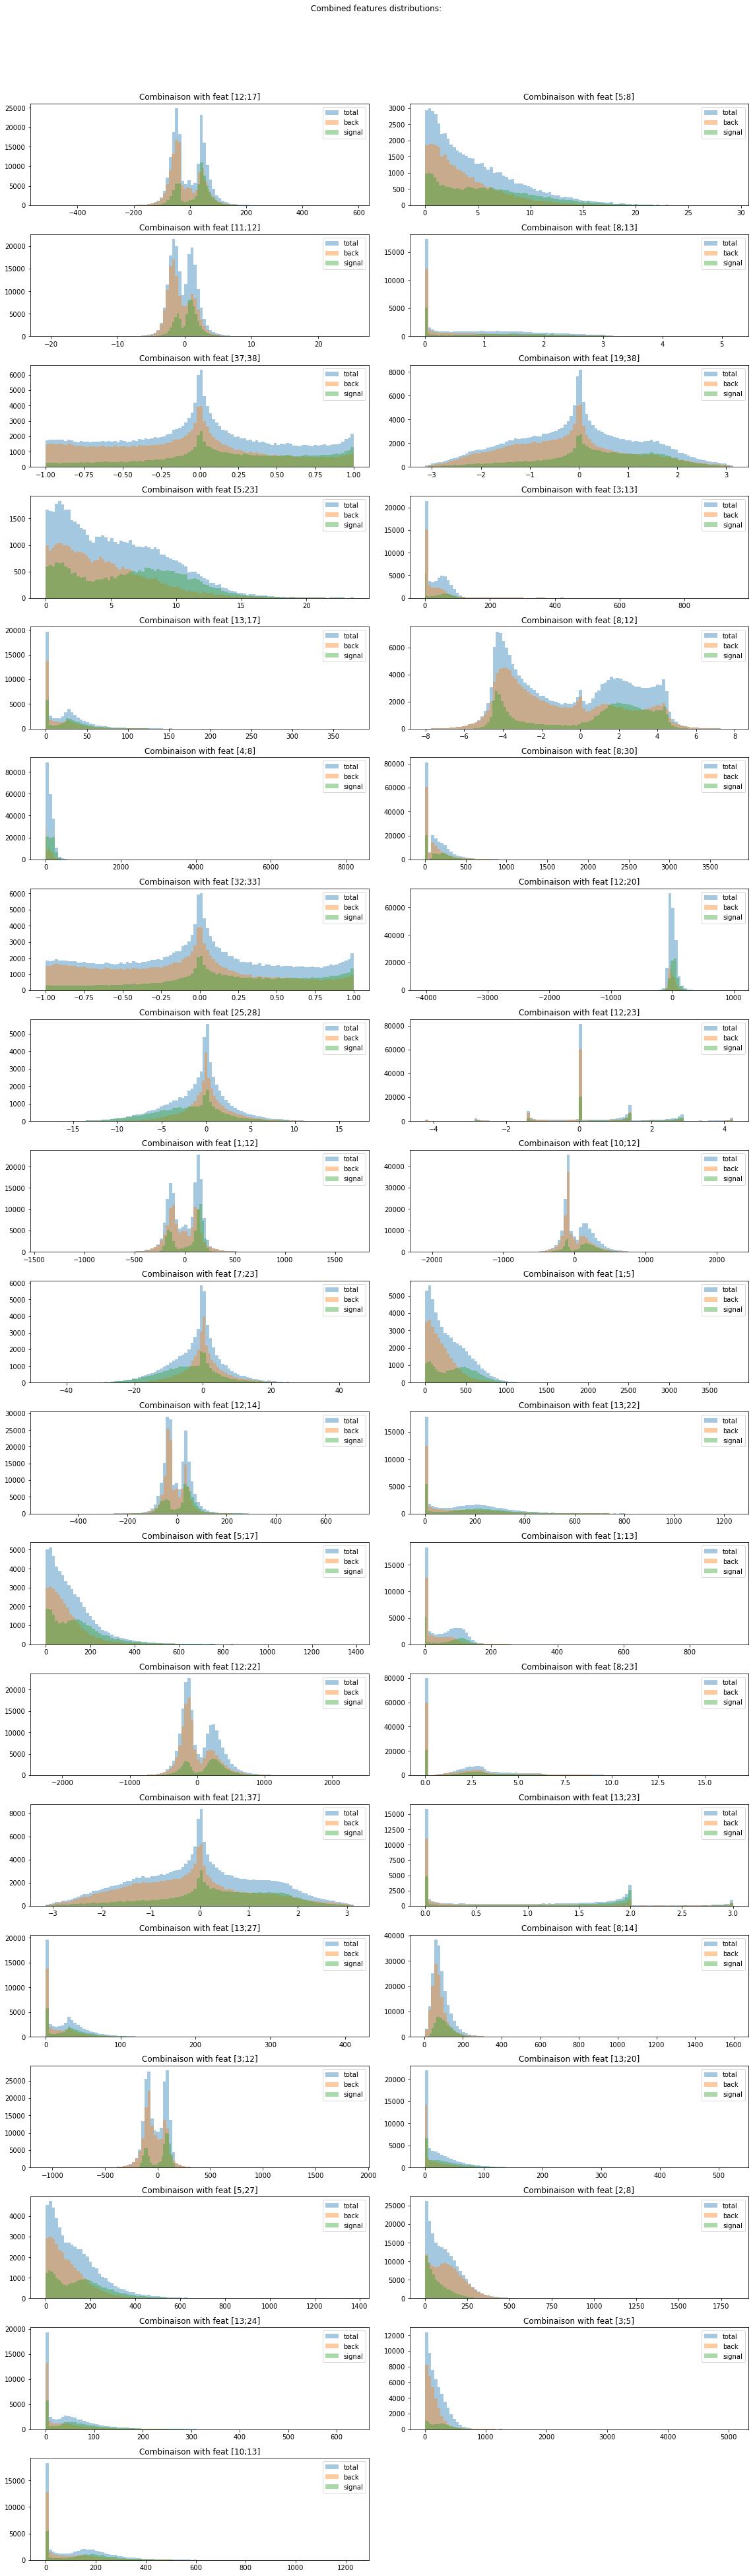

In [100]:


n_lines = np.ceil(len(combs)/2)
plt.figure(figsize=(16, 3*n_lines))

for i, comb in enumerate(combs):
    plt.subplot(n_lines, 2, i+1)
    
    f1 = x_aug[:, comb[0]]
    f2 = x_aug[:, comb[1]]
    ft = f1*f2

    id_keep = ~np.isnan(ft)
    id_b = np.logical_and(y_train == -1, id_keep)
    id_s = np.logical_and(y_train == 1, id_keep)

    plt.hist(ft[id_keep], bins=100, alpha=0.4, label='total')
    plt.hist(ft[id_b], alpha=0.4, bins=100, label='back')
    plt.hist(ft[id_s], alpha=0.4, bins=100, label='signal')
    plt.title('Combinaison with feat [{};{}]'.format(comb[0]+1, comb[1]+1))
    plt.legend()
plt.suptitle('Combined features distributions: ')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Now, we will also add the features based on the nan distributions as discussed above and normalize the data. For each of the 3 types of Nan distributions we will set the value of the NAN-feature to 1 if the initial feature is nan, and to -1 if it was not a Nan

In [101]:
id_nan = [0, 24, 27]
x_aug, header = ml.add_nan_feature(x_aug, id_nan, header)

for i, feature in enumerate(x_aug.T):
    print('Feature {} - {} has range: [{:.4f}, {:.4f}]'.format(
        i+1, header[i], np.nanmin(feature), np.nanmax(feature)))

Feature 1 - DER_mass_MMC has range: [9.2220, 1192.0260]
Feature 2 - DER_mass_transverse_met_lep has range: [0.0000, 690.0750]
Feature 3 - DER_mass_vis has range: [7.2020, 1329.9130]
Feature 4 - DER_pt_h has range: [0.0000, 2834.9990]
Feature 5 - DER_deltaeta_jet_jet has range: [0.0000, 8.5030]
Feature 6 - DER_mass_jet_jet has range: [14.9920, 4543.9130]
Feature 7 - DER_prodeta_jet_jet has range: [-18.0660, 16.6480]
Feature 8 - DER_deltar_tau_lep has range: [0.2240, 5.6840]
Feature 9 - DER_pt_tot has range: [0.0000, 2834.9990]
Feature 10 - DER_sum_pt has range: [46.1040, 1852.4620]
Feature 11 - DER_pt_ratio_lep_tau has range: [0.0470, 19.6720]
Feature 12 - DER_met_phi_centrality has range: [-1.4140, 1.4140]
Feature 13 - DER_lep_eta_centrality has range: [0.0000, 1.0000]
Feature 14 - PRI_tau_pt has range: [20.0000, 622.8620]
Feature 15 - PRI_tau_eta has range: [-2.4990, 2.4970]
Feature 16 - PRI_tau_phi has range: [-3.1420, 3.1420]
Feature 17 - PRI_lep_pt has range: [26.0000, 452.4340]
Fe

Finally, we will add the combined features we designed earlier and remove the angles as we already use their cos and sin that are more meaningful

In [102]:
x_aug = ml.add_features(x_aug, combs) # add features that are product of other features
x_aug = ml.remove_useless(x_aug, id_useless=id_angle) #remove the angles as we used their cos and sin

As a last step we will normalize all our features as if they were normally distributed, even though some are not and set the nan measures to 0 (mean value) so that the don't influence the prediction. We deal with outliers by thresholding them to 2.5 $\sigma$ (the standard deviation)

In [103]:
distrib = ['g']*(x_aug.shape[1])
x_aug, mean_train, std_train, max_train = ml.normalize_outliers(x_aug, distrib) #normalize all the features as gaussian
x_aug = np.nan_to_num(x_aug) #put all nans to 0 (mean value) so that they don't influence the predictions
print('\nStd:', np.std(x_aug, axis=0), '\nn_feat', x_aug.shape[1])

/Users/patryk/GoogleDrive/studies/ML_course/work/ML_course/projects/project1/scripts/ml.py:68: RuntimeWarning: invalid value encountered in less
  mean_update = np.nanmean(feature[np.abs(feat_cent) < maxval])
/Users/patryk/GoogleDrive/studies/ML_course/work/ML_course/projects/project1/scripts/ml.py:69: RuntimeWarning: invalid value encountered in less
  std_update = np.nanstd(feature[np.abs(feat_cent) < maxval])
/Users/patryk/GoogleDrive/studies/ML_course/work/ML_course/projects/project1/scripts/ml.py:71: RuntimeWarning: invalid value encountered in greater
  feat_final[feat_final > maxval] = maxval
/Users/patryk/GoogleDrive/studies/ML_course/work/ML_course/projects/project1/scripts/ml.py:72: RuntimeWarning: invalid value encountered in less
  feat_final[feat_final < -maxval] = -maxval



Std: [ 1.0726  1.0411  1.153   1.1374  0.5503  0.6305  0.5896  1.0194  1.1133
  1.1346  1.1076  1.      0.5385  1.1452  1.      1.1456  1.      1.139
  1.1057  1.      0.8913  0.7753  0.6213  0.5385  1.1306  1.      1.      1.
  0.7747  0.5385  1.      1.      1.      0.7747  0.5385  1.      1.      1.
  1.0365  0.5854  1.0436  0.5471  1.      1.0005  0.5572  0.5633  0.5926
  1.0003  1.0554  1.1073  1.      1.0779  0.5895  1.0825  0.9597  1.0691
  0.588   0.5505  1.0481  0.5711  0.6038  0.5432  1.0411  1.0786  1.0011
  0.5385  0.5864  1.0926  1.0434  0.6113  0.5906  1.066   0.6001  0.5756
  0.5782] 
n_feat 75


Let's quickly apply the same treatment to our validation set :

In [104]:
# normalize features
x_aug_val = x_validation.copy()
x_aug_val, _ = ml.augmented_feat_angle(x_aug_val, id_angle, header)
x_aug_val, _ = ml.add_nan_feature(x_aug_val, id_nan, header)
x_aug_val = ml.add_features(x_aug_val, combs)
x_aug_val = ml.remove_useless(x_aug_val, id_useless=id_angle)
x_aug_val = ml.normalize_outliers_feed(x_aug_val, mean_train, std_train, max_train, distrib)
x_aug_val = np.nan_to_num(x_aug_val)
print('\nStd:', np.std(x_aug_val, axis=0), '\nn_feat', x_aug_val.shape[1])

/Users/patryk/GoogleDrive/studies/ML_course/work/ML_course/projects/project1/scripts/ml.py:88: RuntimeWarning: invalid value encountered in greater
  feat_final[feat_final > maxval]  = maxval
/Users/patryk/GoogleDrive/studies/ML_course/work/ML_course/projects/project1/scripts/ml.py:89: RuntimeWarning: invalid value encountered in less
  feat_final[feat_final < -maxval] = -maxval



Std: [ 1.0762  1.0431  1.1593  1.1389  0.5489  0.6288  0.5858  1.0226  1.1211
  1.1346  1.1126  1.0013  0.5383  1.1451  0.9994  1.1533  0.999   1.1407
  1.1069  1.0039  0.8882  0.7769  0.6227  0.536   1.131   0.9987  0.9984
  0.9978  0.7751  0.539   1.0012  1.0016  1.0022  0.7756  0.5398  0.9956
  0.9995  1.001   1.0435  0.5872  1.0489  0.5466  1.0045  1.003   0.5578
  0.5641  0.5936  1.0028  1.0542  1.1071  0.9976  1.0794  0.5858  1.091
  0.9626  1.0738  0.5858  0.5474  1.0488  0.5745  0.5994  0.5436  1.0436
  1.0791  1.0021  0.5406  0.5886  1.0873  1.0485  0.6087  0.5904  1.0713
  0.6028  0.5718  0.5798] 
n_feat 75


# 2. Model fitting

## 2.1 Least Squares (Normal equations)

In [210]:
weights_ls, degree_ls = lib.test_least_squares(
    x_aug, y_train, x_aug_val, y_validation, degrees = np.linspace(1,6,6))

degree=1, Training RMSE=0.791, Testing RMSE=0.793
train acc :  0.775995
validation acc :  0.77558
Best params for Least Squares : degree =  1 , accuracy =  0.77558


## 2.2 Least Squares (Gradient Descent)

In [211]:
weights_ls, degree_ls = lib.test_least_squares(
    x_aug, y_train, x_aug_val, y_validation, degrees = np.linspace(1,6,6), mode='GD')

Gradient Descent 200 iter: loss=0.3305450979397336
degree=4, Training RMSE=0.813, Testing RMSE=0.814
train acc :  0.769685
validation acc :  0.76662
Best params for Least Squares : degree =  4 , accuracy =  0.76662


## 2.3 Least Squares (Stochastic Gradient Descent)

In [212]:
weights_ls, degree_ls = lib.test_least_squares(
    x_aug, y_train, x_aug_val, y_validation, degrees = np.linspace(1,6,6), mode='SGD')

SGD (batch, iter) = (100, 199): loss=7660681415767385.0
degree=4, Training RMSE=123779492.775, Testing RMSE=125371189.022
train acc :  0.56415
validation acc :  0.56526
Best params for Least Squares : degree =  4 , accuracy =  0.56526


## 2.4 Ridge Regression

For Ridge Regression, we sweeped the degrees from 6 to 13 and the regularize $\lambda$ from $10^{-8}$ to $10^2$. Here, for the sake of speed, we execute a smaller sweep which gives us 83.34% validation accuracy at degree 10 and $\lambda=5.45 * 10^{-6}$

degree=10, lambda=0.000, Training RMSE=0.703, Testing RMSE=0.704
train acc :  0.83303
validation acc :  0.83256
Best params for Ridge regression : degree =  10 , lambda =  5.45e-06 , accuracy =  0.83256


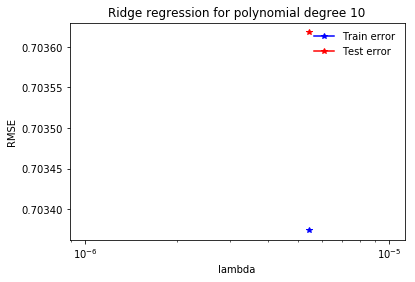

In [213]:
weights_ridge, degree_ridge, lambda_ridge = lib.test_ridge_regression(
    x_aug, y_train, x_aug_val, y_validation, degrees = np.linspace(1,10,1), lambdas=np.logspace(-8,-4, 20))

## 2.5 Logistic Regression (by Newton Method)
For Logistic Regression with  Newton Method, we sweeped the degrees from 1 to 10. $\gamma$=1e-2. We had some problems with Logistic regression numerical errors (loss going to NaN for lots of dims) and that is why we couldnt make it work for Gradient descent for degrees >1. We present here Newton method that is working better.

In [105]:
y_train_log = y_train.copy();
y_train_log[y_train_log == 0] = -1;
weights_log_newton, degree_log_newton = lib.test_logistic_Newton(
    x_aug, y_train, x_aug_val, y_validation, degrees = np.linspace(1,10,1), gamma=1e-2)

STOP it=17, loss=[[ 58925.5009]] 
degree=10, Testing RMSE=0.773
train acc :  0.0
validation acc :  0.77544
Best params for Least Squares : degree =  10 , accuracy =  0.77544


# 3. Model Comparison
The maximum accuracies from different methods have been gathered for different seeds, in order to see what is the variation of the accuracies.

Least Squares   	:  0.77555  +- 0.0029
Least Squares GD  	:  0.76915  +- 0.0059
Least Squares SGD  	:  0.76425  +- 0.0073
Ridge Regr.     	:  0.831766666667  +- 0.0024
Logistic Regr.   	:  0.777683333333  +- 0.006


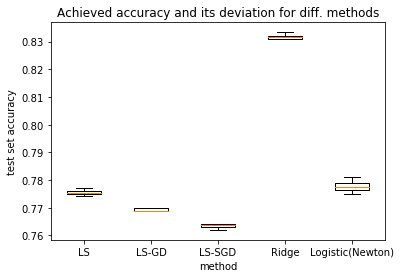

In [108]:
# The maximum accuracies have been gathered for different seeds 
seeds =     [0     , 2      , 3 ,     4,     5,     6]
ls_res =    [0.7771, 0.7742 , 0.776,  0.776 ,0.775, 0.775]
lsgd_res =  [0.7719, 0.770  , 0.769,  0.769, 0.769, 0.766]
lssdg_res = [0.7640, 0.7693 , 0.7632, 0.764, 0.763, 0.762]
ridge_res = [0.8334, 0.8312 , 0.8310, 0.831, 0.832, 0.832]
logistic =  [0.781, 0.777  , 0.7781,  0.776, 0.779,  0.775]

def print_val(name,val):
    print(name,' \t: ', np.mean(val), ' +-',np.abs(np.max(val) - np.min(val)))
    
print_val('Least Squares ',ls_res)
print_val('Least Squares GD',lsgd_res)
print_val('Least Squares SGD',lssdg_res)
print_val('Ridge Regr.   ',ridge_res)
print_val('Logistic Regr. ',logistic)

data = [ls_res, lsgd_res, lssdg_res, ridge_res, logistic]

# don't show outlier points
plt.figure()
plt.boxplot(data, 0, '', labels = ['LS','LS-GD','LS-SGD','Ridge','Logistic(Newton)'])
plt.ylabel('test set accuracy')
plt.xlabel('method')
plt.title('Achieved accuracy and its deviation for diff. methods')
plt.show()

# 4. Submission test

We will here take our best model, use it to classify the test data and generate the csv file for submission

In [26]:
#Load data, add feature and normalize
y_test, x_test, ids_test, header = helper.load_csv_data(DATA_TEST)
x_test[x_test == -999] = np.nan

x_aug_test = x_test.copy()
x_aug_test, _ = ml.augmented_feat_angle(x_aug_test, id_angle, header)
x_aug_test, _ = ml.add_nan_feature(x_aug_test, id_nan, header)
x_aug_test = ml.add_features(x_aug_test, combs)
x_aug_test = ml.remove_useless(x_aug_test, id_useless=id_angle)
x_aug_test = ml.normalize_outliers_feed(x_aug_test, mean_train, std_train, max_train, distrib)
x_aug_test = np.nan_to_num(x_aug_test)
print('\nStd:', np.std(x_aug_test, axis=0),'\nn_feat', x_aug_test.shape[1])

C:\Users\Gaet_2\Documents\EPFL\Machine Learning\projet\ML_course\projects\project1\scripts\ml.py:88: RuntimeWarning: invalid value encountered in greater
  feat_final[feat_final > maxval]  = maxval
C:\Users\Gaet_2\Documents\EPFL\Machine Learning\projet\ML_course\projects\project1\scripts\ml.py:89: RuntimeWarning: invalid value encountered in less
  feat_final[feat_final < -maxval] = -maxval



Std: [ 1.0739  1.0389  1.149   1.1334  0.5516  0.6303  0.5892  1.0158  1.1171
  1.1355  1.107   1.0015  0.5385  1.1449  0.9997  1.1455  1.0002  1.1345
  1.1064  1.0007  0.889   0.7718  0.6213  0.5391  1.1289  0.9991  1.0005
  1.0003  0.7754  0.5394  1.0009  0.9992  0.9997  0.7734  0.5398  0.9992
  1.0005  0.9997  1.0386  0.5883  1.0473  0.5472  0.9993  1.001   0.5594
  0.566   0.5941  1.0026  1.0554  1.1094  1.0007  1.0774  0.5892  1.0828
  0.9623  1.0705  0.5899  0.5546  1.0481  0.5709  0.6038  0.5451  1.0425
  1.0808  1.0004  0.5386  0.5874  1.0877  1.0451  0.6101  0.5913  1.0629
  0.6006  0.5783  0.5797] 
n_feat 75


In [27]:
#Prediction

degree_opt = degree_ridge
weights_opt = weights_ridge

_phi_test = lib.build_poly(x_aug_test, degree_opt)
y_pred = helper.predict_labels(weights_opt, _phi_test)

In [28]:
#Submission
helper.create_csv_submission(ids_test, y_pred, 'final_submit.csv')
print('Results saved ...')

Results saved ...
